# First look at invariant mass

## Imports and definitions

In [1]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

Welcome to JupyROOT 6.26/06
Loaded bin migration and acceptance weights from MC calculations.


## (1) Load data

### (1.1) Load data file

In [2]:
data_path  = "/Users/erezcohen/Desktop/data/CLAS12/RGB/BranchingRatios/sidisdvcs"
subdirname = "sidisdvcs_23Jan2025_commit_0c7e03a" 
data = []
# runs = [6421] #,6422,6426,6429,6430,6431,6432,6433,6437]
runs = [6421,6422,6426,6429,6430,6431,6432,6433,6437]
for run,runIdx in zip(runs,range(10)):
    filename   = "skimmed_BranchingRatios_sidisdvcs_%06d_eep2gX.csv"%run
    fullfile   = data_path + "/" + subdirname + "/" + filename
    data_run = pd.read_csv(fullfile)
    if runIdx==0: data = data_run
    else: data = pd.concat([data,data_run])
    print('Loaded %dk events from run %d'%(len(data_run)/1000,run))
    
print('Loaded %dk events from %s'%(len(data)/1000,subdirname))

Loaded 383k events from run 6421
Loaded 365k events from run 6422
Loaded 326k events from run 6426
Loaded 407k events from run 6429
Loaded 79k events from run 6430
Loaded 320k events from run 6431
Loaded 398k events from run 6432
Loaded 444k events from run 6433
Loaded 153k events from run 6437
Loaded 2878k events from sidisdvcs_23Jan2025_commit_0c7e03a


### (1.2) Add cuts not previously imposed

Following G. Matousek 
"Measurements of Beam Spin Asymmetries of $\pi^\pm \pi^0$ dihadrons at CLAS12 using Gradient Boosted Trees

https://www.jlab.org/Hall-B/shifts/admin/paper_reviews/2024/PiPi0_AnalysisNote_(3)_3.pdf-7600066-2024-03-09-v1.pdf


1. $E(\gamma_1) > 10$ MeV and $E(\gamma_2) > 10$ MeV,
2. $5^\circ < \theta < 35^\circ$ for all reconstructed particles (forward detector) 
3. $E(PCAL) > 0$
4. PCAL calorimeter coordinates $lv$ and $lw$ within [14,400] cm
5. $0.9 < \beta(\gamma) < 1.1$

In [3]:
Eg_min = 0.0100
data_after_cuts = data[(data["g1_E"]>Eg_min) & (data["g2_E"]>Eg_min)]
print('Retained %dk events after energy cut'%(len(data_after_cuts)/1000))

Theta_min = 5  * 3.14/180.
Theta_max = 35 * 3.14/180.
data_after_cuts = data_after_cuts[  (Theta_min < data_after_cuts["e_Theta"])  & (data_after_cuts["e_Theta"] < Theta_max) 
                                  & (Theta_min < data_after_cuts["p_Theta"])  & (data_after_cuts["p_Theta"] < Theta_max) 
                                  & (Theta_min < data_after_cuts["g1_Theta"]) & (data_after_cuts["g1_Theta"] < Theta_max) 
                                  & (Theta_min < data_after_cuts["g2_Theta"]) & (data_after_cuts["g2_Theta"] < Theta_max) ]
print('Retained %dk events after theta cut'%(len(data_after_cuts)/1000))

EPCAL_min = 0
data_after_cuts = data_after_cuts[(EPCAL_min < data_after_cuts["g1_E_PCAL"]) & (EPCAL_min < data_after_cuts["g2_E_PCAL"])]
print('Retained %dk events after PCAL energy cut'%(len(data_after_cuts)/1000))




PCAL_V_min, PCAL_V_max = 14,400
PCAL_W_min, PCAL_W_max = 14,400
data_after_cuts = data_after_cuts[  (PCAL_V_min < data_after_cuts["g1_PCAL_V"]) & (data_after_cuts["g1_PCAL_V"] < PCAL_V_max)                    
                                  & (PCAL_W_min < data_after_cuts["g1_PCAL_W"]) & (data_after_cuts["g1_PCAL_W"] < PCAL_W_max)
                                  & (PCAL_V_min < data_after_cuts["g2_PCAL_V"]) & (data_after_cuts["g2_PCAL_V"] < PCAL_V_max)                    
                                  & (PCAL_W_min < data_after_cuts["g2_PCAL_W"]) & (data_after_cuts["g2_PCAL_W"] < PCAL_W_max)]
print('Retained %dk events after PCAL coordinates cut'%(len(data_after_cuts)/1000))


beta_min, beta_max = 0.9,1.1
data_after_cuts = data_after_cuts[  (beta_min < data_after_cuts["g1_beta"]) & (data_after_cuts["g1_beta"] < beta_max)                    
                                  & (beta_min < data_after_cuts["g2_beta"]) & (data_after_cuts["g2_beta"] < beta_max)]
print('Retained %dk events after beta(gamma) cut'%(len(data_after_cuts)/1000))

Retained 2287k events after energy cut
Retained 1842k events after theta cut
Retained 880k events after PCAL energy cut
Retained 726k events after PCAL coordinates cut
Retained 657k events after beta(gamma) cut


In [4]:

Eg_min = 1.2 # GeV
data_after_Eg_min_cut = data_after_cuts[(data_after_cuts["g1_E"] > Eg_min) & (data_after_cuts["g2_E"] > Eg_min)]
print('Retained %dk events after %0.1f GeV < E(gamma) cut'%(len(data_after_Eg_min_cut)/1000,Eg_min))

pi0_Mmin = 0.09
pi0_Mmax = 0.18
data_after_pi0_cut = data_after_Eg_min_cut[(pi0_Mmin < data_after_Eg_min_cut["Mgg"]) & (data_after_Eg_min_cut["Mgg"] < pi0_Mmax)]
print('Retained %dk events after %.1f < Mgg < %.1f GeV cut'%(len(data_after_pi0_cut)/1000,pi0_Mmin,pi0_Mmax))

Retained 19k events after 1.2 GeV < E(gamma) cut
Retained 6k events after 0.1 < Mgg < 0.2 GeV cut


$M_x(\gamma^* d \to p \gamma \gamma) $ 

In [5]:
Mx_min = 0 #39
data_after_Mx_cuts = data_after_Eg_min_cut[ Mx_min < data_after_Eg_min_cut["M_x_deep2g"]]
print('Retained %dk events after Mx cut'%(len(data_after_Mx_cuts)/1000))


data_after_Mx_pi0_cut = data_after_Mx_cuts[(pi0_Mmin < data_after_Mx_cuts["Mgg"]) & (data_after_Mx_cuts["Mgg"] < pi0_Mmax)]
print('Retained %dk events after %.1f < Mgg < %.1f GeV cut'%(len(data_after_Mx_pi0_cut)/1000,pi0_Mmin,pi0_Mmax))

Retained 18k events after Mx cut
Retained 6k events after 0.1 < Mgg < 0.2 GeV cut


## Add angles with respect to $\vec{q}$

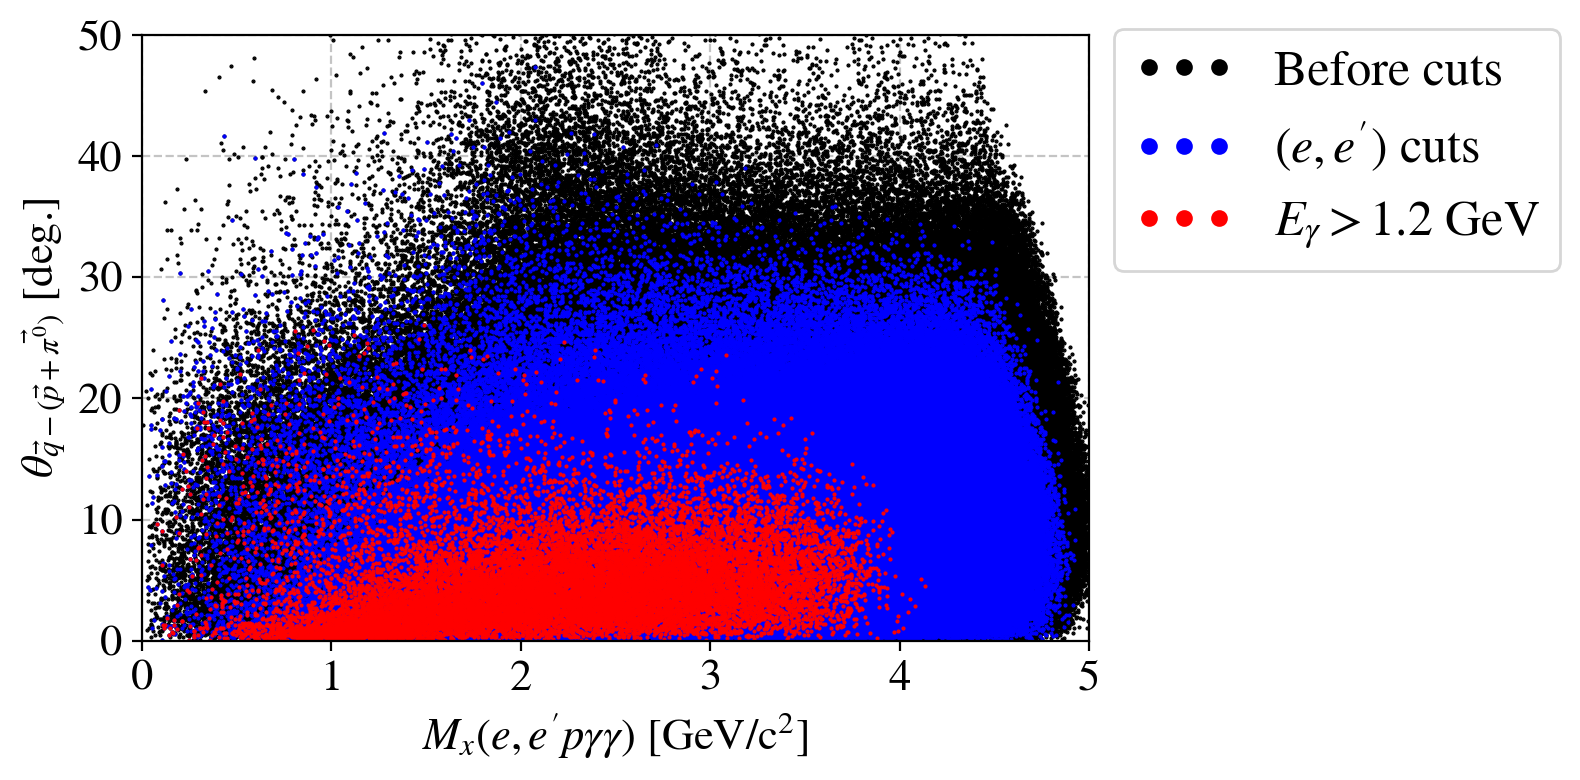

In [11]:
df = data_after_Mx_pi0_cut; #data_after_Mx_cuts;

fig = plt.figure(figsize=(8,4),tight_layout = True)
ax = fig.add_subplot(1,1,1)
for df,color,label in zip([data,data_after_cuts,data_after_Eg_min_cut],#,data_after_Mx_pi0_cut],
                          ['k' ,'b'            ,'r'                  ],#,'cyan'],
                          ['Before cuts',"$(e,e')$ cuts", '$E_\gamma > %.1f$ GeV'%Eg_min]):#,"$M_{\gamma\gamma}\sim\pi^0$"]):
    x = df["M_x_deep2g"]
    y = df["theta_q_pm"]*180./3.14
    # ax.scatter(x,y,1,color=color,label=label);
    ax.plot(x,y,'.',markersize=1,color=color,label=label);    
    
set_axes(ax,"$M_x(e,e'p\gamma\gamma)$ [GeV/c$^2$]","$\\theta_{\\vec{q}-(\\vec{p}+\\vec{\\pi^0})}$ [deg.]",
         xlim=(0,5), ylim=(0,50),
         fontsize=16,
         do_add_grid=True);
ax.legend(bbox_to_anchor=(1,1.05),fontsize=18, markerscale=10, numpoints=3);

In [15]:
deg = 3.141528 / 180;
Mx_min, Mx_max = 0.5, 1.5
theta_q_pm_min = 0
theta_q_pm_max = 2 # [deg]

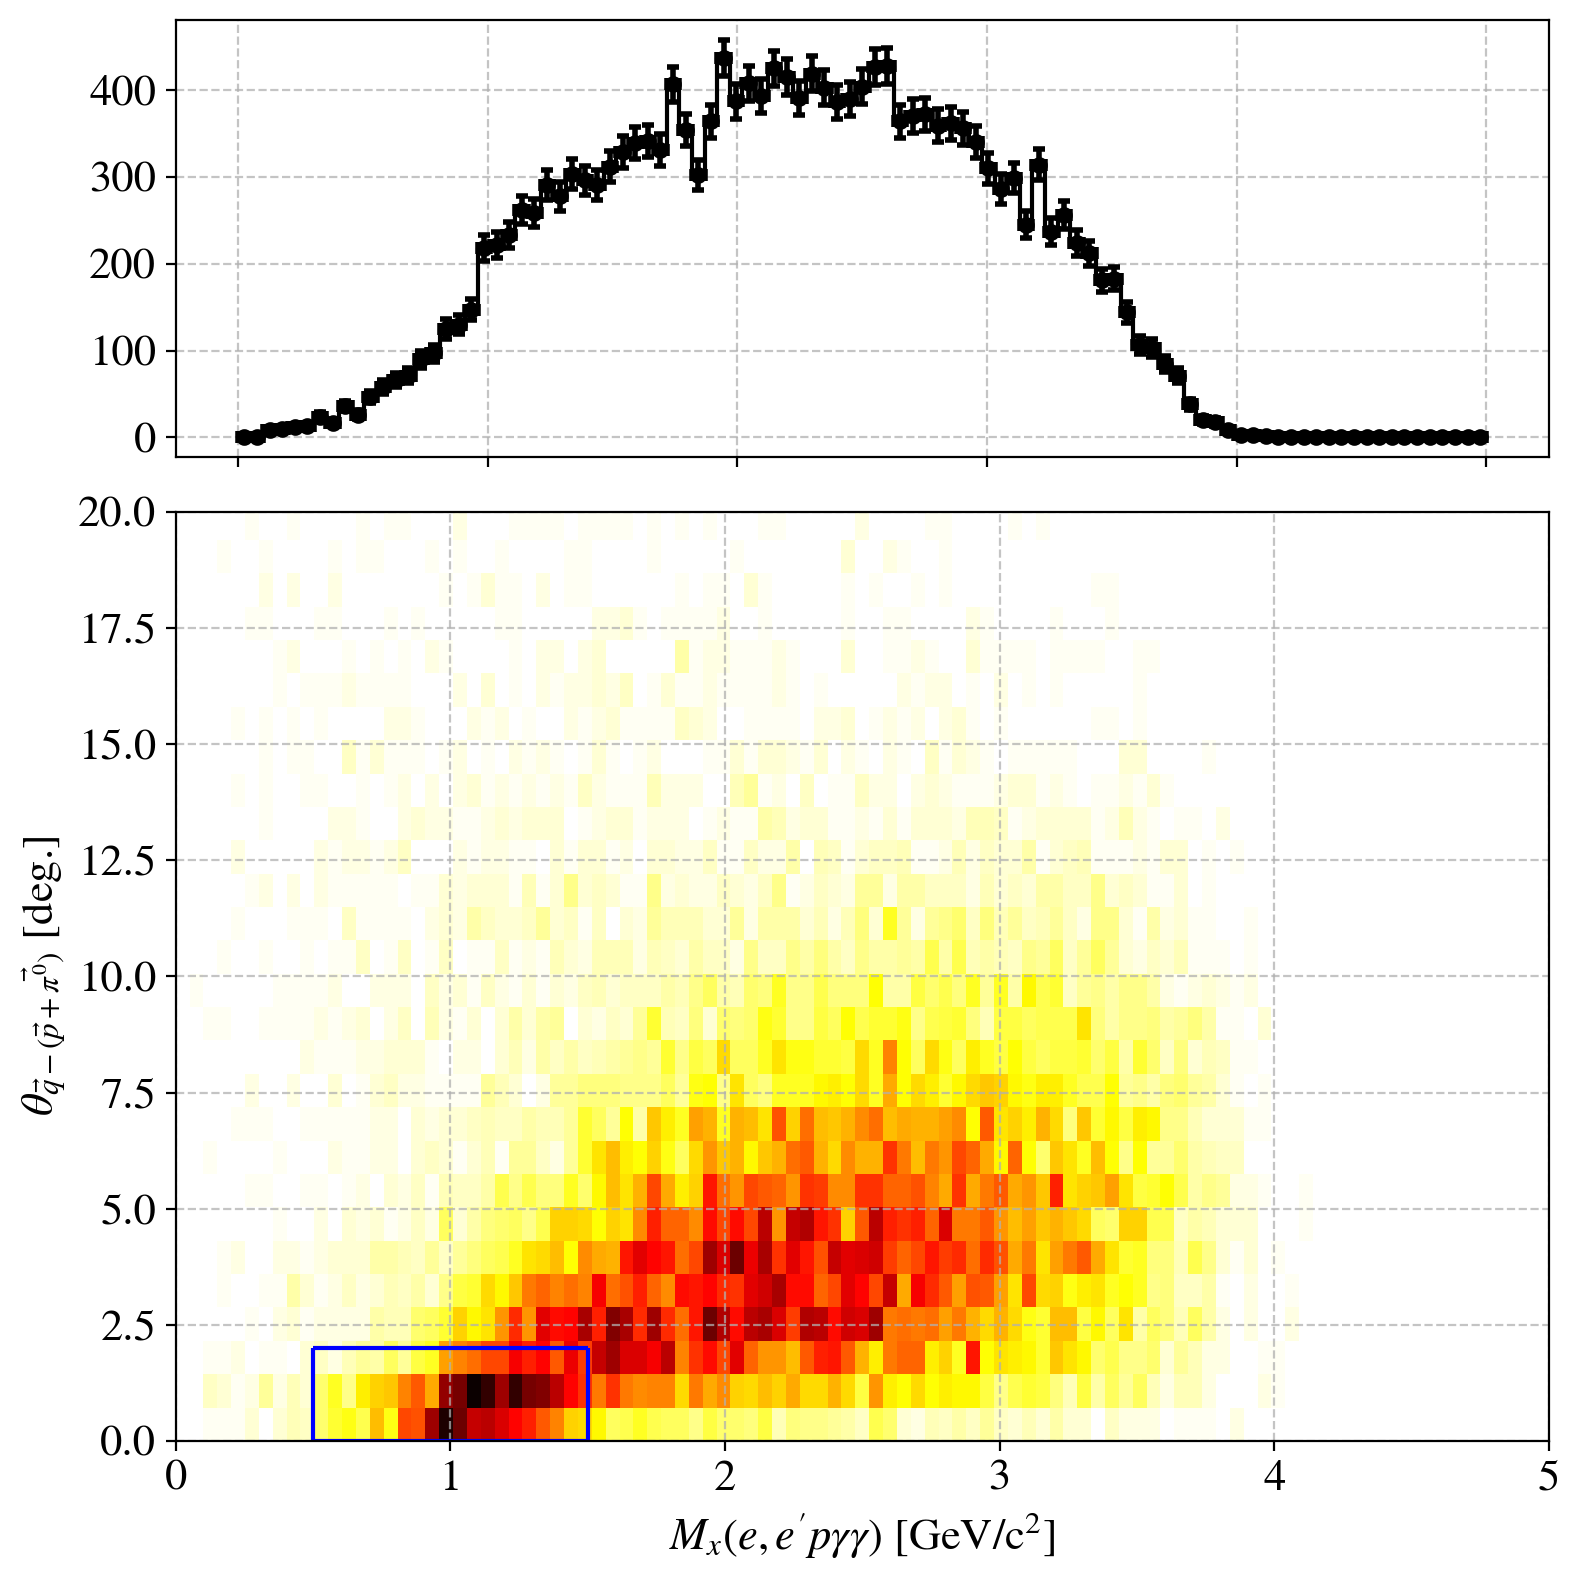

In [18]:
bins_Mx    = np.linspace(0,5,100)

df = data_after_Eg_min_cut; #data_after_Mx_pi0_cut; #data_after_Mx_cuts;
x = df["M_x_deep2g"]
y = df["theta_q_pm"]*180./3.14
bins_theta = np.linspace(0,np.max(y),50)
fig = plt.figure(figsize=(8,8),tight_layout = True)
ax = fig.add_subplot(3,1,(2,3))
plot_2d_hist(x,y,bins=(bins_Mx,bins_theta),ax=ax); #,norm='log');
# ax.scatter(x,y,1,color='k');
set_axes(ax,"$M_x(e,e'p\gamma\gamma)$ [GeV/c$^2$]","$\\theta_{\\vec{q}-(\\vec{p}+\\vec{\\pi^0})}$ [deg.]",fontsize=16,do_add_grid=True, ylim=(0,20));
plt.hlines(theta_q_pm_min,Mx_min, Mx_max,color='b')
plt.hlines(theta_q_pm_max,Mx_min, Mx_max,color='b')
plt.vlines(Mx_min, theta_q_pm_min, theta_q_pm_max,color='b')
plt.vlines(Mx_max, theta_q_pm_min, theta_q_pm_max,color='b')

ax = fig.add_subplot(3,1,1)
plot_step_hist(x,bins=bins_Mx);
set_axes(ax,"","",fontsize=16,do_add_grid=True,remove_ticks_x=True);

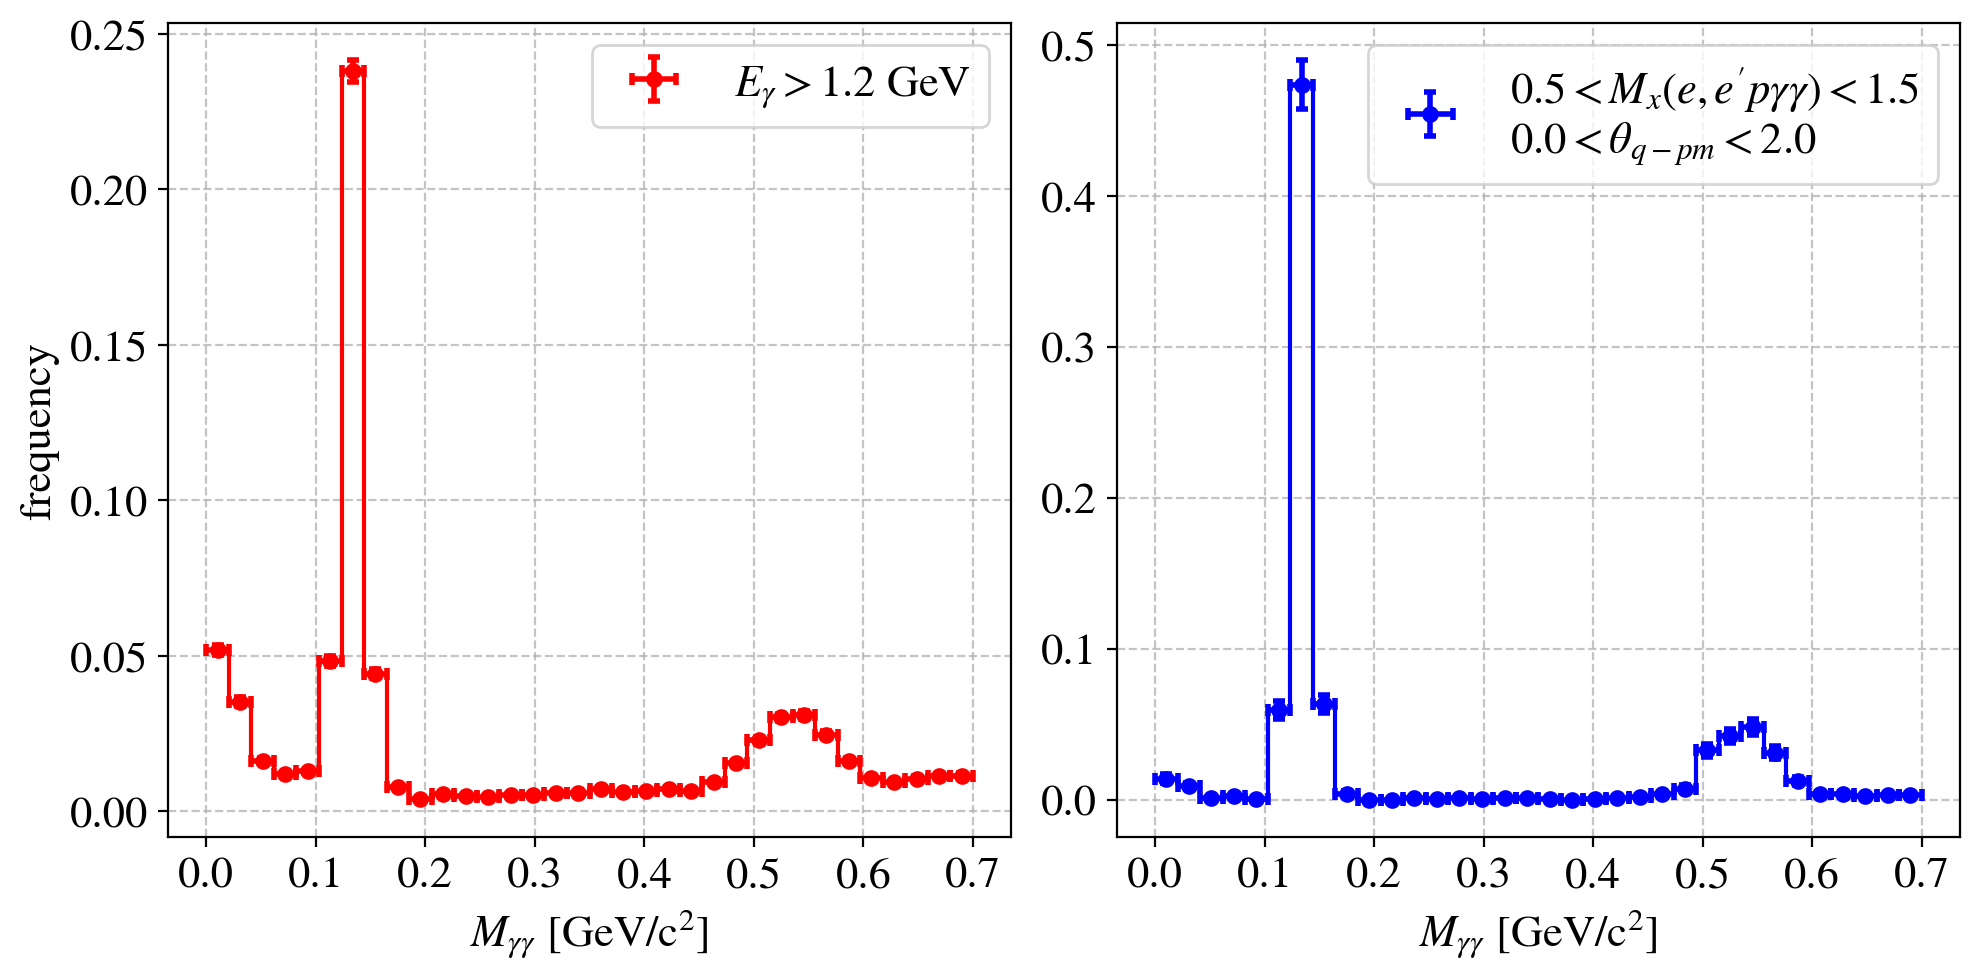

In [30]:
bins_Mgg    = np.linspace(0,0.7,35)
fig = plt.figure(figsize=(10,5),tight_layout = True)


df = data_after_Eg_min_cut
data_after_Mx_theta_q_pm_cut = df[  (Mx_min < df["M_x_deep2g"]) & (df["M_x_deep2g"] < Mx_max) 
                                  & (theta_q_pm_min*deg < df["theta_q_pm"]) & (df["theta_q_pm"] < theta_q_pm_max*deg) ]

for df,color,label,i in zip([data_after_Eg_min_cut, data_after_Mx_theta_q_pm_cut],#,data_after_Mx_pi0_cut],
                          ['r' , 'b'                  ],
                          ['$E_\gamma > %.1f$ GeV'%Eg_min, 
                           "$%.1f < M_x(e,e'p\gamma\gamma) < %.1f$\n$%.1f < \\theta_{q-pm} < %.1f$"%(Mx_min,Mx_max,theta_q_pm_min,theta_q_pm_max)],range(2)):
    x = df["Mgg"]
    ax = fig.add_subplot(1,2,i+1)
    plot_step_hist(x,bins=bins_Mgg,label=label,color=color, ScaleFactor=1./len(df)); 

    set_axes(ax,"$M_{\gamma\gamma}$ [GeV/c$^2$]","frequency" if i==0 else '',
             fontsize=16,do_add_grid=True,do_add_legend=True);
# ax.set_yscale('log')

In [35]:
def extract_Ratio_eta_pi0(Eg_min   = 1.0,  df=None, var = "Mgg",
                           bins_Mgg = np.linspace(0,0.8,50),
                           pi0_Mmin = 0.09,
                           pi0_Mmax = 0.18, 
                           eta_Mmin= 0.45, 
                           eta_Mmax= 0.62):
    
    Mgg = (bins_Mgg[1:] + bins_Mgg[:-1])/2

    data_sliced = df[(df["g1_E"] > Eg_min) & (df["g2_E"] > Eg_min)]
    x = data_after_Mx_cuts["g1_E"]
    y = data_after_Mx_cuts["g2_E"]

    h_sliced,_ = np.histogram(data_sliced[var],  bins=bins_Mgg)
    bg_level = np.mean( h_sliced[20:30] )
    h_bkg    = bg_level * np.ones(len(Mgg))
    h_no_bkg = h_sliced - h_bkg

    idx_pi0_Mmin  = int(np.argwhere(Mgg > pi0_Mmin)[0])
    idx_pi0_Mmax  = int(np.argwhere(Mgg > pi0_Mmax)[0])
    idx_eta_Mmin  = int(np.argwhere(Mgg > eta_Mmin)[0])
    idx_eta_Mmax  = int(np.argwhere(Mgg > eta_Mmax)[0])
    N_pi0         = np.sum(h_no_bkg[idx_pi0_Mmin:idx_pi0_Mmax])
    N_pi0_err     = np.sqrt( np.sum(h_no_bkg[idx_pi0_Mmin:idx_pi0_Mmax]) ) 
    N_eta         = np.sum(h_sliced[idx_eta_Mmin:idx_eta_Mmax] - h_bkg[idx_eta_Mmin:idx_eta_Mmax])
    N_eta_err     = np.sqrt( np.sum(h_no_bkg[idx_eta_Mmin:idx_eta_Mmax]) ) 


    if N_pi0>0 and N_eta>0:
        R_eta_pi0    = N_eta/N_pi0
        R_eta_pi0_err= R_eta_pi0 * np.sqrt( np.square(N_eta_err/N_eta) + np.square(N_pi0_err/N_pi0) ) 
    else :
        R_eta_pi0    = 0
        R_eta_pi0_err= 0
    
    results = dict()
    # results['data_sliced'] = data_sliced
    results['bg_level']      = bg_level
    results['Mgg']           = Mgg
    results['h_all']         = h_sliced
    results['h_bkg']         = h_bkg
    results['N_pi0']         = N_pi0
    results['N_pi0_err']     = N_pi0_err
    results['N_eta']         = N_eta
    results['N_eta_err']     = N_eta_err
    results['idx_pi0_Mmin']  = idx_pi0_Mmin
    results['idx_pi0_Mmax']  = idx_pi0_Mmax
    results['idx_eta_Mmin']  = idx_eta_Mmin
    results['idx_eta_Mmax']  = idx_eta_Mmax
    results['R_eta_pi0']     = R_eta_pi0
    results['R_eta_pi0_err'] = R_eta_pi0_err
    
    return results

In [36]:
results = extract_Ratio_eta_pi0(Eg_min   = 1.2, df=data_after_Mx_theta_q_pm_cut,
                           bins_Mgg = np.linspace(0,0.8,50),
                           pi0_Mmin = 0.09,
                           pi0_Mmax = 0.18, 
                           eta_Mmin= 0.45, 
                           eta_Mmax= 0.62)
results

{'bg_level': 2.8,
 'Mgg': array([0.00816327, 0.0244898 , 0.04081633, 0.05714286, 0.07346939,
        0.08979592, 0.10612245, 0.12244898, 0.13877551, 0.15510204,
        0.17142857, 0.1877551 , 0.20408163, 0.22040816, 0.23673469,
        0.25306122, 0.26938776, 0.28571429, 0.30204082, 0.31836735,
        0.33469388, 0.35102041, 0.36734694, 0.38367347, 0.4       ,
        0.41632653, 0.43265306, 0.44897959, 0.46530612, 0.48163265,
        0.49795918, 0.51428571, 0.53061224, 0.54693878, 0.56326531,
        0.57959184, 0.59591837, 0.6122449 , 0.62857143, 0.64489796,
        0.66122449, 0.67755102, 0.69387755, 0.71020408, 0.72653061,
        0.74285714, 0.75918367, 0.7755102 , 0.79183673]),
 'h_all': array([ 21,  18,   5,   4,   3,   1,  13, 353, 642,  73,   5,   3,   0,
          0,   2,   1,   2,   3,   1,   3,   2,   2,   0,   0,   1,   2,
          3,   5,   5,   8,  38,  58,  64,  71,  44,  26,  15,   6,   3,
          5,   2,   5,   7,   8,  12,   7,   1,   4,   6]),
 'h_bkg': array([

## Cut on $\theta < \theta_{min}$

In [8]:
theta_q_pm_Mmax = 2 * deg
data_after_theta_q_pm_cut = data_after_Mx_pi0_cut[data_after_Mx_pi0_cut["theta_q_pm"] < theta_q_pm_Mmax]
print('Retained %dk events after theta_q_pm < %.1f deg. cut'%(len(data_after_theta_q_pm_cut)/1000,theta_q_pm_Mmax*180/3.14))

Retained 1k events after theta_q_pm < 2.0 deg. cut


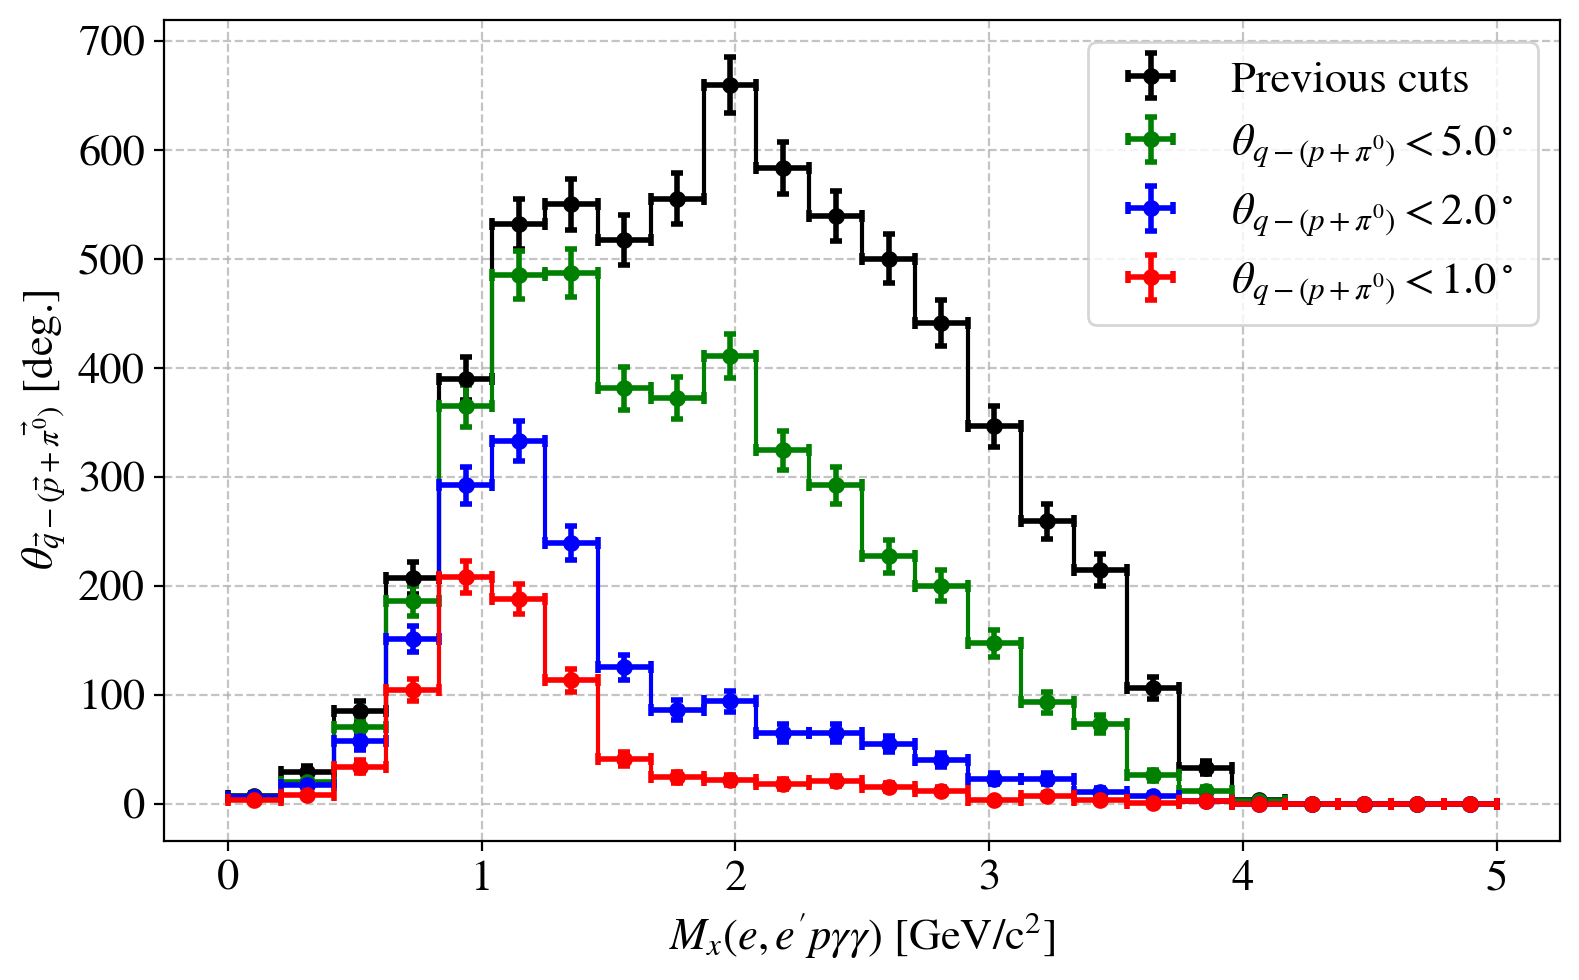

In [9]:
bins_Mx    = np.linspace(0,5,25)
fig = plt.figure(figsize=(8,5),tight_layout = True)
ax = fig.add_subplot(1,1,1)

x = data_after_Mx_pi0_cut["M_x_deep2g"]
plot_step_hist(x,bins=bins_Mx,label="Previous cuts",color='k'); # ,ScaleFactor=1./len(x)


for theta_q_pm_Mmax,color in zip([5*deg, 2*deg , 1*deg],                                       
                                 ['g'   ,'b'    ,'r']):
    
    df = data_after_Mx_pi0_cut[data_after_Mx_pi0_cut["theta_q_pm"] < theta_q_pm_Mmax]
    x = df["M_x_deep2g"]
    label = '$\\theta_{q-(p+\\pi^0)} < %.1f^\circ$ '%(theta_q_pm_Mmax*180/3.14)
    plot_step_hist(x,bins=bins_Mx,label=label,color=color); # ,ScaleFactor=1./len(x)

set_axes(ax,"$M_x(e,e'p\gamma\gamma)$ [GeV/c$^2$]","$\\theta_{\\vec{q}-(\\vec{p}+\\vec{\\pi^0})}$ [deg.]",
         fontsize=16,do_add_grid=True,do_add_legend=True);
# ax.set_yscale('log')

## Other angles

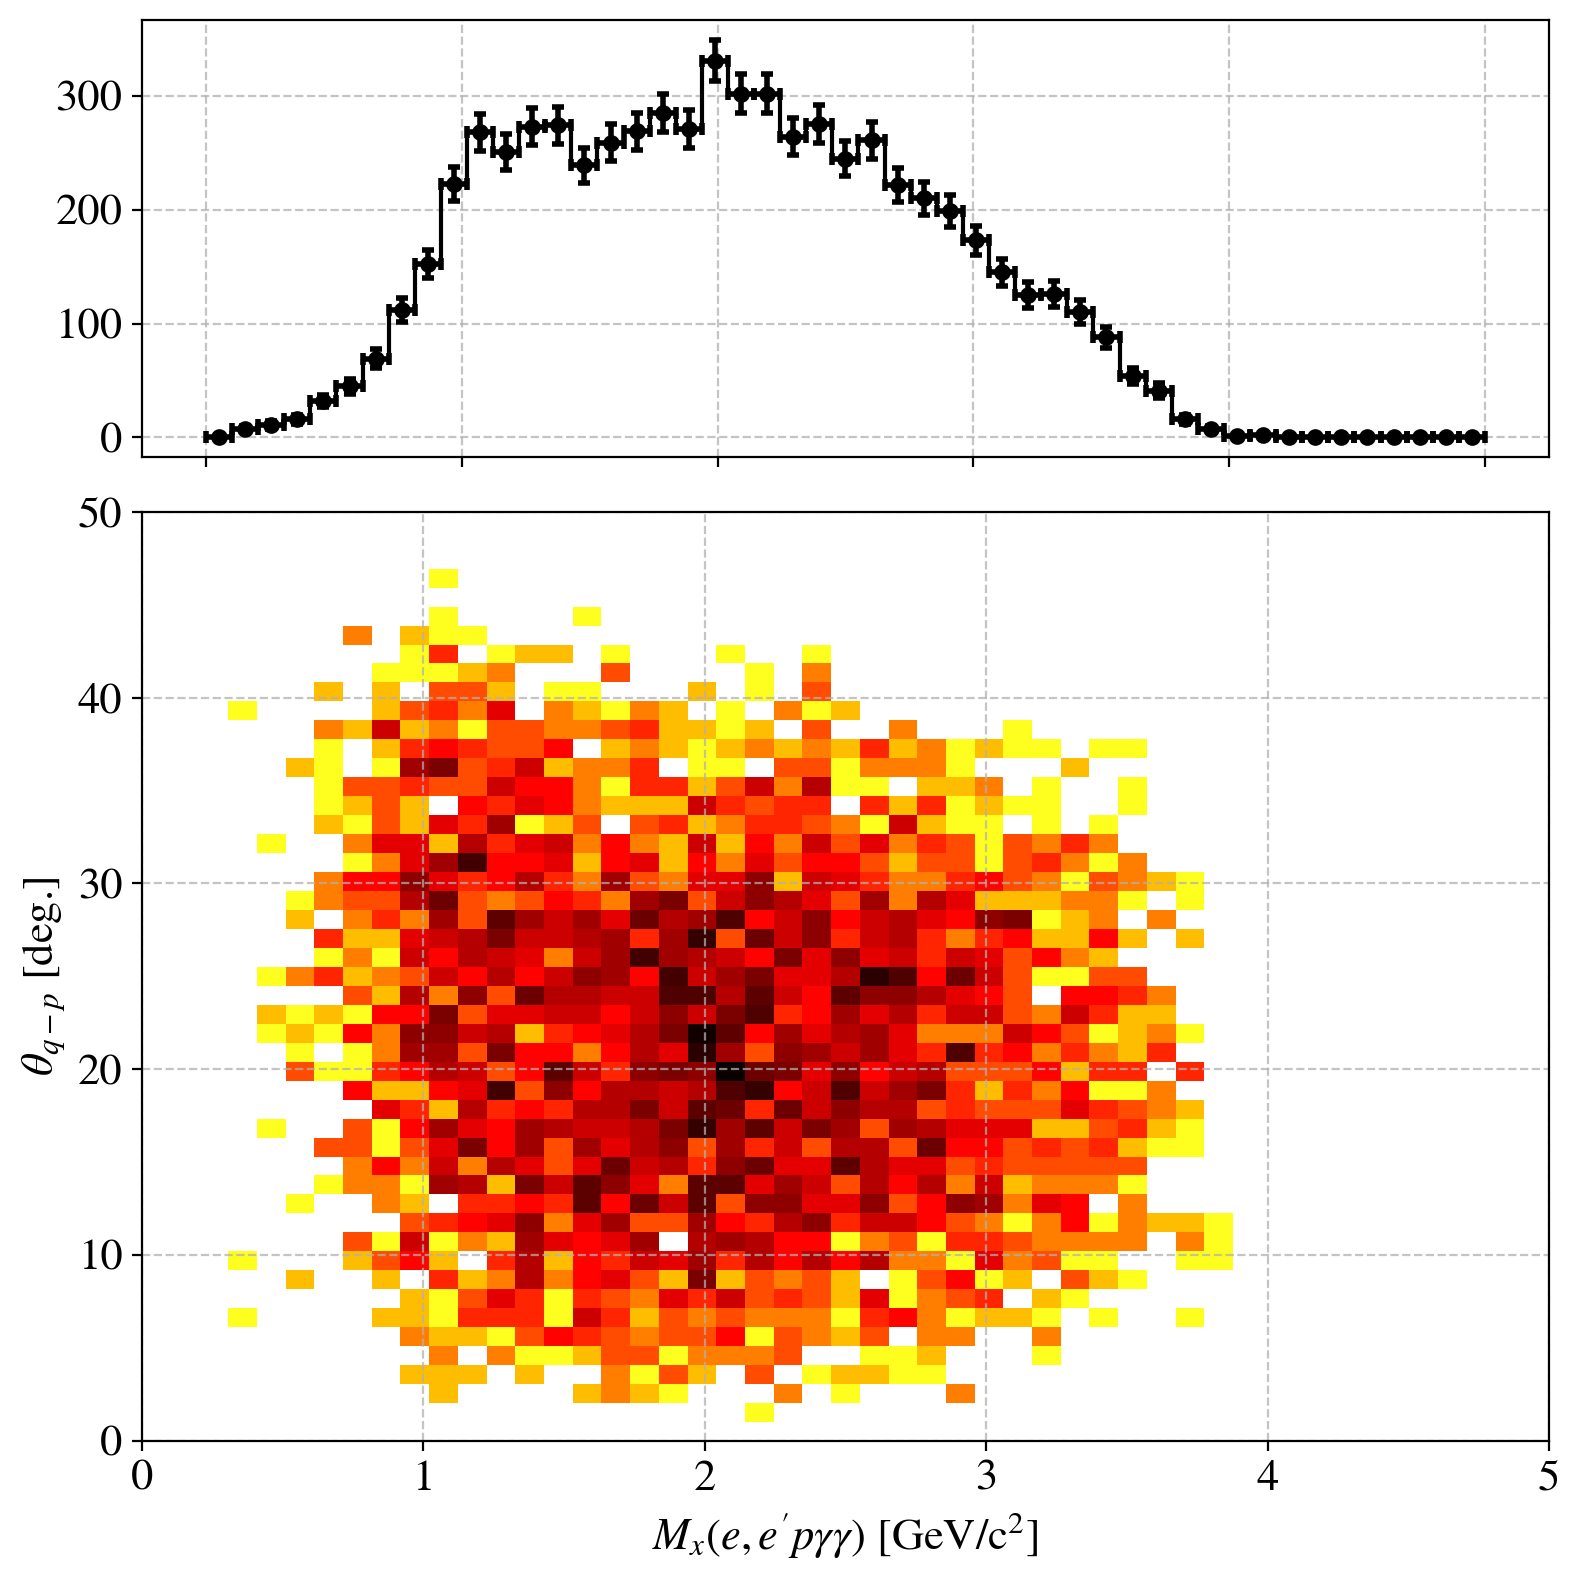

In [123]:
bins_theta = np.linspace(0,50,50)
bins_Mx    = np.linspace(0,5,50)

df = data_after_Mx_pi0_cut; #data_after_Mx_cuts;
x = df["M_x_deep2g"]
y = df["theta_q_p"]*180./3.14
fig = plt.figure(figsize=(8,8),tight_layout = True)
ax = fig.add_subplot(3,1,(2,3))
plot_2d_hist(x,y,bins=(bins_Mx,bins_theta),ax=ax,norm='log');

set_axes(ax,"$M_x(e,e'p\gamma\gamma)$ [GeV/c$^2$]","$\\theta_{q-p}$ [deg.]",fontsize=16,do_add_grid=True);

ax = fig.add_subplot(3,1,1)
plot_step_hist(x,bins=bins_Mx);
set_axes(ax,"","",fontsize=16,do_add_grid=True,remove_ticks_x=True);
# ax.set_zscale('log')

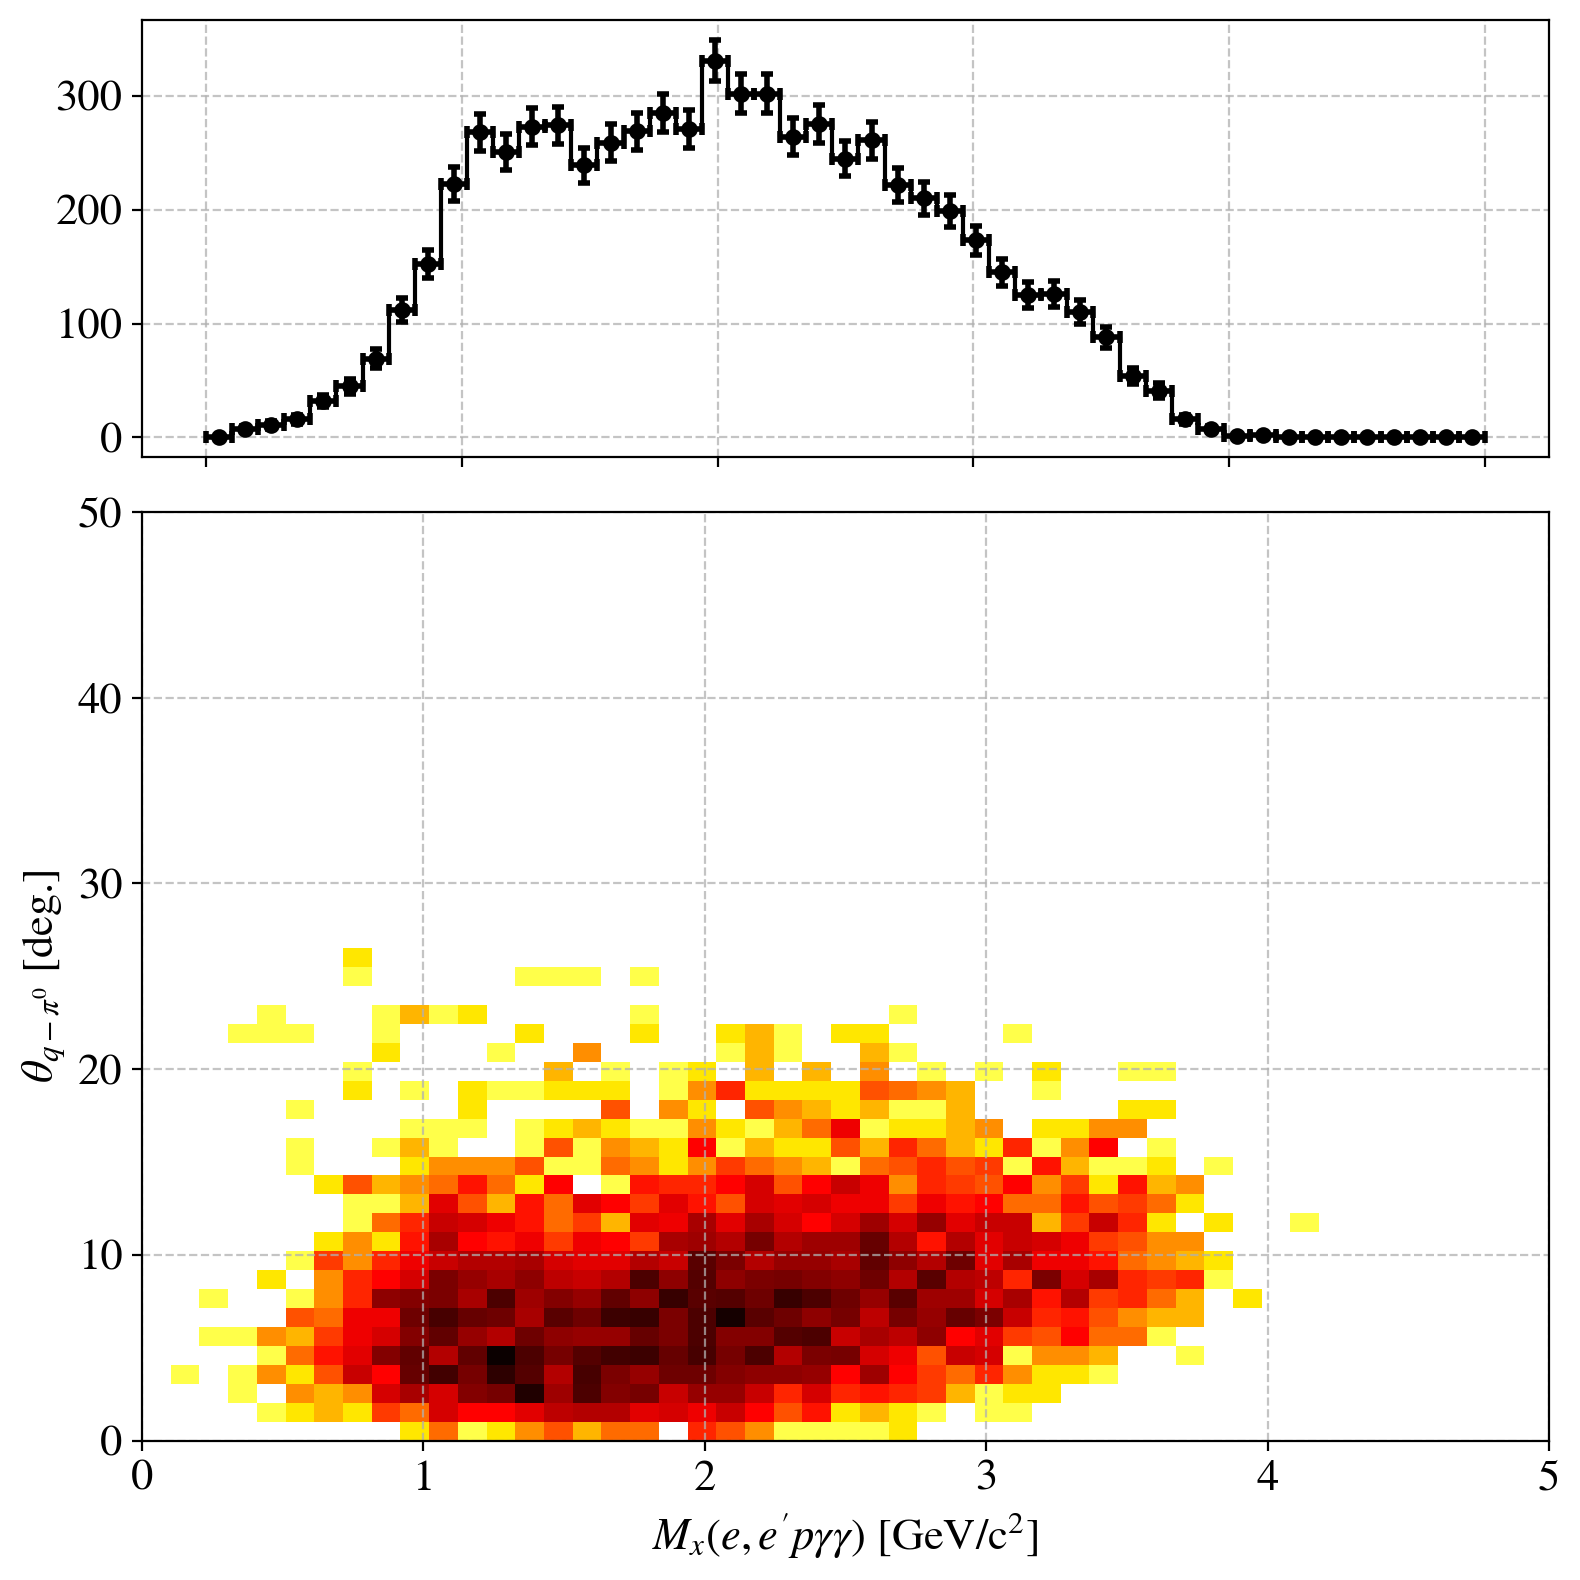

In [124]:
bins_theta = np.linspace(0,50,50)
bins_Mx    = np.linspace(0,5,50)

df = data_after_Mx_pi0_cut; #data_after_Mx_cuts;
x = df["M_x_deep2g"]
y = df["theta_q_m"]*180./3.14
fig = plt.figure(figsize=(8,8),tight_layout = True)
ax = fig.add_subplot(3,1,(2,3))
plot_2d_hist(x,y,bins=(bins_Mx,bins_theta),ax=ax,norm='log');

set_axes(ax,"$M_x(e,e'p\gamma\gamma)$ [GeV/c$^2$]","$\\theta_{q-\\pi^0}$ [deg.]",fontsize=16,do_add_grid=True);

ax = fig.add_subplot(3,1,1)
plot_step_hist(x,bins=bins_Mx);
set_axes(ax,"","",fontsize=16,do_add_grid=True,remove_ticks_x=True);
# ax.set_zscale('log')